In [1]:
# Install packages
!pip install pennylane pennylane-lightning pennylane-lightning[gpu] cotengra quimb --upgrade
!pip install tifffile
#!pip install -U "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install --upgrade "jax[cuda11_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


In [2]:
# Import packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import numpy as np
#np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
from sklearn import datasets
import seaborn as sns
import jax
import time
from tifffile import tifffile
import functools

from typing import List, Union, Tuple, Dict, Optional, Any
from typing import Callable

jax.config.update("jax_enable_x64", True)
#jax.config.update("jax_debug_nans", True)
import jax.numpy as jnp

import optax  # optimization using jax

import torch  # https://pytorch.org
import torchvision  # https://pytorch.org
#torch.set_printoptions(profile="full")
import pennylane as qml
import pennylane.numpy as pnp

import os, cv2, itertools # cv2 -- OpenCV
import shutil
import zipfile
%matplotlib inline

from jax.lib import xla_bridge

def set_jax_platform():
    # Check if TPU is available
    try:
        tpu_backend = xla_bridge.get_backend('tpu')
        if tpu_backend and tpu_backend.device_count() > 0:
            # Set platform to TPU
            jax.config.update('jax_platform_name', 'tpu')
            print("Set platform to TPU")
            return
    except RuntimeError:
        pass  # No TPU found, move on to check for GPU

    # Check if GPU is available
    try:
      gpu_backend = xla_bridge.get_backend('gpu')
      if gpu_backend and gpu_backend.device_count() > 0:
          # Set platform to CUDA (GPU)
          jax.config.update('jax_platform_name', 'gpu')
          print("Set platform to GPU")
    except RuntimeError:
          # Set platform to CPU
          jax.config.update('jax_platform_name', 'cpu')
          print("Set platform to CPU")

# Call the function to set the platform
set_jax_platform()

sns.set()

seed = 1701
rng = np.random.default_rng(seed=seed)
prng = pnp.random.default_rng(seed=seed)
jrng_key = jax.random.PRNGKey(seed)

Set platform to GPU


# Data Loading and Preprocessing

In [3]:
ROWS, COLS = 32, 32

# Extract data from https://www.kaggle.com/datasets/kmader/siim-medical-images
data_zip = '/content/drive/MyDrive/Research/CTMedicalImages/archive.zip'

# extract the file
with zipfile.ZipFile(data_zip, 'r') as zip_ref:
    zip_ref.extractall(os.getcwd())

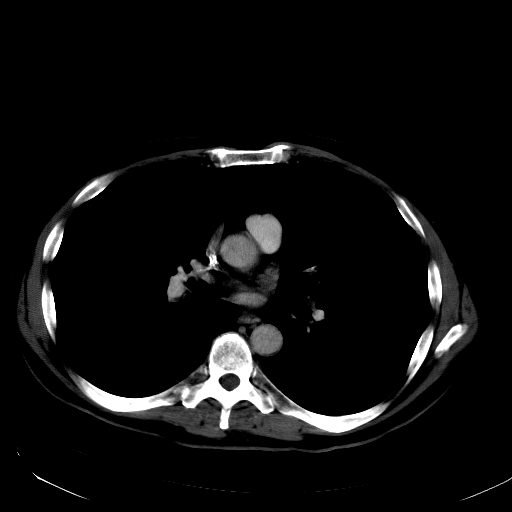

In [4]:
from google.colab.patches import cv2_imshow
overview_df = pd.read_csv('overview.csv')
overview_df.columns = ['id']+list(overview_df.columns[1:])
overview_df['Contrast'] = overview_df['Contrast'].map(lambda x: 1 if x else 0) #1 for contrast, 0 for no contrast
dummy_img = tifffile.imread(os.path.join('tiff_images', overview_df['tiff_name'][0]))
cv2_imshow(dummy_img)

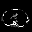

In [5]:
resized = cv2.resize(dummy_img, (ROWS, COLS),interpolation=cv2.INTER_CUBIC)
cv2_imshow(resized)

In [6]:
def read_tiff_and_resize(filepath, resize_row = 32, resize_col = 32):
  img = tifffile.imread(filepath)
  return cv2.resize(img, (resize_row, resize_col),interpolation=cv2.INTER_CUBIC)



class CTImgHerm(torch.utils.data.Dataset):
    def __init__(self, overview_csv='overview.csv', tiff_img_folder='tiff_images', resize_col = 32, resize_row = 32):
        self.overview_df = pd.read_csv('overview.csv')
        self.overview_df.columns = ['idx']+list(overview_df.columns[1:])
        self.overview_df['Contrast'] = overview_df['Contrast'].map(lambda x: 1 if x else 0) #1 for contrast, 0 for no contrast
        self.resize_col = resize_col
        self.resize_row = resize_row

        self.data = []

        for i in range(len(self.overview_df)):
          img = read_tiff_and_resize(os.path.join(tiff_img_folder, overview_df['tiff_name'][i]), resize_row = self.resize_row , resize_col =self.resize_col)
          img = cv2.normalize(img, None, 0, 1.0,cv2.NORM_MINMAX, dtype=cv2.CV_32F)
          label = self.overview_df['Contrast'][i]
          self.data.append((img, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        img = (img + np.transpose(img))/2
        return img, label

dummy_dataset = CTImgHerm()
dummy_dataset[0]

(array([[0.00067681, 0.00067681, 0.00067681, ..., 0.00067681, 0.00067681,
         0.00067681],
        [0.00067681, 0.00067681, 0.00067681, ..., 0.00858719, 0.00069783,
         0.00067681],
        [0.00067681, 0.00067681, 0.00067681, ..., 0.05319135, 0.00705113,
         0.00054893],
        ...,
        [0.00067681, 0.00858719, 0.05319135, ..., 0.07699811, 0.0740454 ,
         0.04863514],
        [0.00067681, 0.00069783, 0.00705113, ..., 0.0740454 , 0.41830966,
         0.02946547],
        [0.00067681, 0.00067681, 0.00054893, ..., 0.04863514, 0.02946547,
         0.00067681]], dtype=float32),
 1)

# Time-Evolve the Image Hermitian

In [7]:
def img_hermitian_evolve(
    img:jnp.ndarray,
    t:float
)->jnp.ndarray:
  assert img.shape[-1]==32 and img.shape[-2] == 32, f"The shape of the image must be 32 by 32, got {img.shape[-2]} by {img.shape[-1]}"
  return jax.scipy.linalg.expm(img*( -0.5j*t))

print(
    img_hermitian_evolve(
        dummy_dataset[0][0],
        10
        )[16]
    )

[ 0.03316844+0.10185404j  0.03990275+0.01448886j -0.01340644-0.11395645j
 -0.09734296-0.04602236j -0.02874829-0.106155j    0.03417749-0.02312764j
  0.31355867-0.00824642j -0.02404682+0.14984632j -0.2005266 -0.04882969j
  0.1439579 +0.08981134j  0.19900478-0.21086909j -0.27399284+0.07857362j
 -0.06780978-0.2594946j   0.2664748 -0.00677681j  0.0567608 -0.00824443j
 -0.0677962 -0.04115503j  0.11816133-0.20410216j -0.08650939-0.03623088j
 -0.0455427 +0.09426481j  0.15362464+0.02755839j  0.07865278-0.17987871j
 -0.0714988 +0.21788616j  0.08791466-0.09473691j  0.01336809+0.02959433j
  0.23885596-0.01219569j  0.15551725-0.15525933j  0.02743046-0.07152437j
  0.18937172+0.15392636j -0.07521363+0.05503959j -0.04855046-0.09508035j
 -0.04012337-0.05201134j  0.05081476-0.175945j  ]


# Some Utilities

In [8]:
ket = {
    '0':jnp.array([1,0]),
    '1':jnp.array([0,1]),
    '+':(jnp.array([1,0]) + jnp.array([0,1]))/jnp.sqrt(2),
    '-':(jnp.array([1,0]) - jnp.array([0,1]))/jnp.sqrt(2)
}

pauli = {
    'I':jnp.array([[1,0],[0,1]]),
    'X':jnp.array([[0,1],[1,0]]),
    'Y':jnp.array([[0, -1j],[1j, 0]]),
    'Z':jnp.array([[1,0],[0,-1]])
}

def tensor_product(*args):
  input_list = [a for a in args]
  return functools.reduce(jnp.kron, input_list)

def multi_qubit_identity(n_qubits:int)->jnp.ndarray:
  assert n_qubits>0
  if n_qubits == 1:
    return pauli['I']
  else:
    return tensor_product(*[pauli['I'] for _ in range(n_qubits)])

pauli_words_su4 = {}
for key1 in pauli.keys():
  for key2 in pauli.keys():
    if not (key1==key2 and key1=='I' and key2=='I'):
      pauli_words_su4[key1+key2] = tensor_product(pauli[key1], pauli[key2])

pauli_words_su8 = {}
for key1 in pauli.keys():
  for key2 in pauli.keys():
    for key3 in pauli.keys():
      if not key1+key2+key3 == 'III':
        pauli_words_su8[key1+key2+key3] = tensor_product(pauli[key1], pauli[key2], pauli[key3])

pauli_words_su16 = {}
for key1 in pauli.keys():
  for key2 in pauli.keys():
    for key3 in pauli.keys():
      for key4 in pauli.keys():
        if not key1+key2+key3+key4 == 'IIII':
          pauli_words_su16[key1+key2+key3+key4] = tensor_product(
              pauli[key1],
              pauli[key2],
              pauli[key3],
              pauli[key4]
          )

pauli_words_su32 = {}
for key1 in pauli.keys():
  for key2 in pauli.keys():
    for key3 in pauli.keys():
      for key4 in pauli.keys():
        for key5 in pauli.keys():
          if not key1+key2+key3+key4+key5 == 'IIIII':
            pauli_words_su32[key1+key2+key3+key4+key5] = tensor_product(
                pauli[key1],
                pauli[key2],
                pauli[key3],
                pauli[key4],
                pauli[key5]
            )

observables_2_cls_5q = [0]*2
for i in ['0', '1']:
      idx = int(i, 2)
      basis_state =ket[i]
      single_qubit_obs = jnp.outer(basis_state, basis_state)
      observables_2_cls_5q[idx] = tensor_product(single_qubit_obs, multi_qubit_identity(4))

print(observables_2_cls_5q)

[Array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64), Array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int64)]


In [9]:
def su4_op(
    params:jnp.ndarray
):
  generator = jnp.einsum("i, ijk -> jk", params, jnp.asarray(list(pauli_words_su4.values())))
  return jax.scipy.linalg.expm(1j*generator)

def brickwall_su4_5q_single_layer(
    params:jnp.ndarray
):
  """
  A brickwall layer of su4 gates on 5 qubits.
  Second stack is three su4 on qubit pairs (1,2), (3,4)
  First stack is two su4 on qubit pairs (2,3), (4,5)
  """
  second_stack = tensor_product(
      su4_op(params[:15]),
      su4_op(params[15:30]),
      multi_qubit_identity(1)
  )
  first_stack = tensor_product(
      multi_qubit_identity(1),
      su4_op(params[30:45]),
      su4_op(params[45:60]),
  )
  return jnp.dot(second_stack, first_stack)

def su32_op(
    params:jnp.ndarray
):
  generator = jnp.einsum("i, ijk - >jk", params, jnp.asarray(list(pauli_words_su32.values())))
  return jax.scipy.linalg.expm(1j*generator)

test_params = jax.random.normal(shape=[60], key=jrng_key)
print(brickwall_su4_5q_single_layer(test_params).shape)

(32, 32)


In [10]:
def measure_sv(
    state:jnp.ndarray,
    observable:jnp.ndarray
    ):
  """
  Measure a statevector with a Hermitian observable.
  Note: No checking Hermitianicity of the observable or whether the observable
  has all real eigenvalues or not
  """
  expectation_value = jnp.dot(jnp.conj(state.T), jnp.dot(observable, state))
  return jnp.real(expectation_value)

def measure_dm(
    rho:jnp.ndarray,
    observable:jnp.ndarray
):
  """
  Measure a density matrix with a Hermitian observable.
  Note: No checking Hermitianicity of the observable or whether the observable
  has all real eigenvalues or not.
  """
  product = jnp.dot(rho, observable)

  # Calculate the trace, which is the sum of diagonal elements
  trace = jnp.trace(product)

  # The expectation value should be real for physical observables
  return jnp.real(trace)

vmap_measure_sv = jax.vmap(measure_sv, in_axes=(None, 0), out_axes=0)
vmap_measure_dm = jax.vmap(measure_dm, in_axes=(None, 0), out_axes=0)

def bitstring_to_state(bitstring:str):
  """
  Convert a bit string, like '0101001' or '+-+-101'
  to a statevector. Each character in the bitstring must be among
  0, 1, + and -
  """
  assert len(bitstring)>0
  for c in bitstring:
    assert c in ['0', '1', '+', '-']
  single_qubit_states = [ket[c] for c in bitstring]
  return tensor_product(*single_qubit_states)

# The QNN

With data re-uploading

$$
|{\varphi(\theta,t)}\rangle = \Pi_n (\mathrm{ParameterisedLayers}(\theta_n) e^{-\frac{it_n}{2}M} )|+\rangle^{\otimes 5}
$$

In [11]:
def qnn_hamevo(
    params:jnp.ndarray,
    t:jnp.ndarray,
    img:jnp.ndarray
)->jnp.ndarray:
  """
  A QNN that takes (M+M^T)/2
  as input, where M is the (rescaled) original image,
  as well as a trainable parameter t,
  and parameters for the trainable layers
  and output an array of 2 elements representing classification logits
  """
  single_op_params = 60 #4**5-1

  n_outer_layers = len(t)
  n_inner_layers = (len(params)//single_op_params)//n_outer_layers
  state = tensor_product(ket['+'], ket['+'], ket['+'], ket['+'], ket['+'])
  for i in range(n_outer_layers):
    state = jnp.dot(
      img_hermitian_evolve(img, t[i]),
      state
      )
    inner_layer_params = params[i*(single_op_params*n_inner_layers):(i+1)*(single_op_params*n_inner_layers)]
    for j in range(n_inner_layers):
      state = jnp.dot(
          brickwall_su4_5q_single_layer(inner_layer_params[j*single_op_params:(j+1)*single_op_params]),#su32_op(inner_layer_params[j*single_op_params:(j+1)*single_op_params]),
          state
      )
  return vmap_measure_sv(state, jnp.asarray(observables_2_cls_5q))



print(
    qnn_hamevo(
        jax.random.normal(shape=[60*15], key=jrng_key),
        jax.random.normal(shape=[15], key=jrng_key),
        dummy_dataset[0][0]
    )
)

[0.44247169 0.55752831]


# Training

In [12]:
@jax.jit
def compute_out(weight,t, features, labels):
    """Computes the output of the corresponding label in the qcnn"""
    out = lambda weight,t, feature, label: qnn_hamevo(weight,t, feature)
    return jax.vmap(out, in_axes=(None,None,  0, 0), out_axes=0)(
        weight,t, features, labels
    )


def compute_accuracy(weight,t, features, labels):
    """Computes the accuracy over the provided features and labels"""
    out = compute_out(weight,t, features, labels)
    pred = jnp.argmax(out, axis = 1)
    return jnp.sum(jnp.array(pred == labels).astype(int)) / len(out)


def compute_cost(weight,t, features, labels):
    """Computes the cost over the provided features and labels"""
    logits = compute_out(weight,t, features, labels)
    return jnp.nanmean(optax.softmax_cross_entropy_with_integer_labels(logits, labels))


value_and_grad = jax.jit(jax.value_and_grad(compute_cost, argnums=[0,1]))

In [18]:
N_OUTER_LAYERS = 2
N_INNER_LAYERS = 1
N_LAYERS = N_OUTER_LAYERS*N_INNER_LAYERS
SINGLE_OP_PARAMS  = 60 #4**5-1

def init_weights():
    return jax.random.normal(shape=[SINGLE_OP_PARAMS*N_LAYERS], key=jrng_key),jax.random.normal(shape=[N_OUTER_LAYERS], key=jrng_key)

In [19]:
def train_vqc(batchsize:int, n_epochs:int, seed:int=1701):
  start = time.time()
  pnp.random.seed(seed)
  np.random.seed(seed)
  # load data
  full_dataset = CTImgHerm()
  train_size = int(0.8 * len(full_dataset))
  test_size = len(full_dataset) - train_size
  train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
  trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batchsize, shuffle=True
  )
  testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batchsize, shuffle=True
  )
  # Exponential decay of the learning rate.
  scheduler = optax.exponential_decay(
    init_value=0.01,
    transition_steps=n_epochs,
    decay_rate=0.99)

  # Combining gradient transforms using `optax.chain`.
  gradient_transform = optax.chain(
    optax.clip(1.0),
    optax.scale_by_adam(),  # Use the updates from adam.
    optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler.
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
  )
  # init weights and optimizer
  weights, weights_last = init_weights()
  opt_state = gradient_transform.init((weights, weights_last))
  #data containers
  train_cost_epochs, test_cost_epochs, train_acc_epochs, test_acc_epochs = [], [], [], []
  for step in range(n_epochs):
        train_cost_batches = []
        train_acc_batches = []
        test_cost_batches = []
        test_acc_batches = []
        epoch_start = time.time()
        print(f"Training at Epoch {step+1}/{n_epochs}, Train batches {len(trainloader)}, Test batches {len(testloader)}......")
        for batch, (x_train, y_train) in enumerate(trainloader):
          batch_start = time.time()
          # Training step with (adam) optimizer
          x_train, y_train = jnp.asarray(x_train.numpy()), jnp.asarray(y_train.numpy())
          train_cost, grad_circuit = value_and_grad(weights, weights_last, x_train, y_train)
          updates, opt_state = gradient_transform.update(grad_circuit, opt_state)
          weights, weights_last = optax.apply_updates((weights, weights_last), updates)
          train_acc = compute_accuracy(weights, weights_last, x_train, y_train)
          train_cost_batches.append(train_cost)
          train_acc_batches.append(train_acc)
          if len(trainloader)<= 5 or (batch+1)%5==0:
            print(f"Training at Epoch {step+1}/{n_epochs}, Batch {batch+1}, Cost {train_cost}, Acc {train_acc}. Time {time.time()-batch_start}")


        train_cost_epochs.append(np.mean(train_cost_batches))
        train_acc_epochs.append(np.mean(train_acc_batches))


        # load test data
        for batch, (x_test, y_test) in enumerate(testloader):
          batch_start = time.time()
          x_test, y_test = jnp.asarray(x_test.numpy()), jnp.asarray(y_test.numpy())
          # compute accuracy and cost on testing data
          test_out = compute_out(weights, weights_last, x_test, y_test)
          test_pred = jnp.argmax(test_out, axis=1)
          test_acc = jnp.sum(jnp.array(test_pred == y_test).astype(int)) / len(test_out)
          test_cost = jnp.nanmean(optax.softmax_cross_entropy_with_integer_labels(test_out, y_test))
          test_cost_batches.append(test_cost)
          test_acc_batches.append(test_acc)
          if len(testloader)<= 5 or (batch+1)%5==0:
            print(f"Testing at Epoch {step+1}/{n_epochs}, Batch {batch+1}, Cost {test_cost}, Acc {test_acc}. Time {time.time()-batch_start}")
        test_acc_epochs.append(np.mean(test_acc_batches))
        test_cost = np.mean(test_cost_batches)
        test_cost_epochs.append(test_cost)
        print("......")
        print(f"Epoch {step+1}/{n_epochs}, Train: Cost {np.mean(train_cost_batches)}, Acc {np.mean(train_acc_batches)}")
        print(f"Epoch {step+1}/{n_epochs}, Test: Cost {test_cost}, Acc {test_acc}. Time {time.time()-epoch_start}")
        print("=-="*10)

  return dict(
        n_train=[train_size] * n_epochs,
        step=np.arange(1, n_epochs + 1, dtype=int).tolist(),
        train_cost=[c.astype(float) for c in train_cost_epochs],
        train_acc=[c.astype(float) for c in train_acc_epochs],
        test_cost=[c.astype(float) for c in test_cost_epochs],
        test_acc=[c.astype(float) for c in test_acc_epochs],
    )

In [20]:
n_epochs = 500
n_reps = 20
batch_size = 5000

train_sizes = [int(0.8 * len(CTImgHerm()))]

def run_iterations():
    results_df = pd.DataFrame(
        columns=["train_acc", "train_cost", "test_acc", "test_cost", "step", "n_train"]
    )

    for _ in range(n_reps):
        results = train_vqc(n_epochs=n_epochs, batchsize=batch_size)
        results_df = pd.concat(
            [results_df, pd.DataFrame.from_dict(results)], axis=0, ignore_index=True
        )

    return results_df

results_df = run_iterations()

Training at Epoch 1/500, Train batches 1, Test batches 1......


/usr/local/lib/python3.10/dist-packages/jax/_src/lax/lax.py:2660: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


Streaming output truncated to the last 5000 lines.
Epoch 286/500, Test: Cost 0.6491505420857443, Acc 0.65. Time 0.049353599548339844
=-==-==-==-==-==-==-==-==-==-=
Training at Epoch 287/500, Train batches 1, Test batches 1......
Training at Epoch 287/500, Batch 1, Cost 0.5513827682488122, Acc 0.7875. Time 0.036748647689819336
Testing at Epoch 287/500, Batch 1, Cost 0.6492119528050294, Acc 0.65. Time 0.011759042739868164
......
Epoch 287/500, Train: Cost 0.5513827682488122, Acc 0.7875
Epoch 287/500, Test: Cost 0.6492119528050294, Acc 0.65. Time 0.054113149642944336
=-==-==-==-==-==-==-==-==-==-=
Training at Epoch 288/500, Train batches 1, Test batches 1......
Training at Epoch 288/500, Batch 1, Cost 0.5513581858740485, Acc 0.7875. Time 0.03621983528137207
Testing at Epoch 288/500, Batch 1, Cost 0.6492741113786644, Acc 0.65. Time 0.012070417404174805
......
Epoch 288/500, Train: Cost 0.5513581858740485, Acc 0.7875
Epoch 288/500, Test: Cost 0.6492741113786644, Acc 0.65. Time 0.05348706245

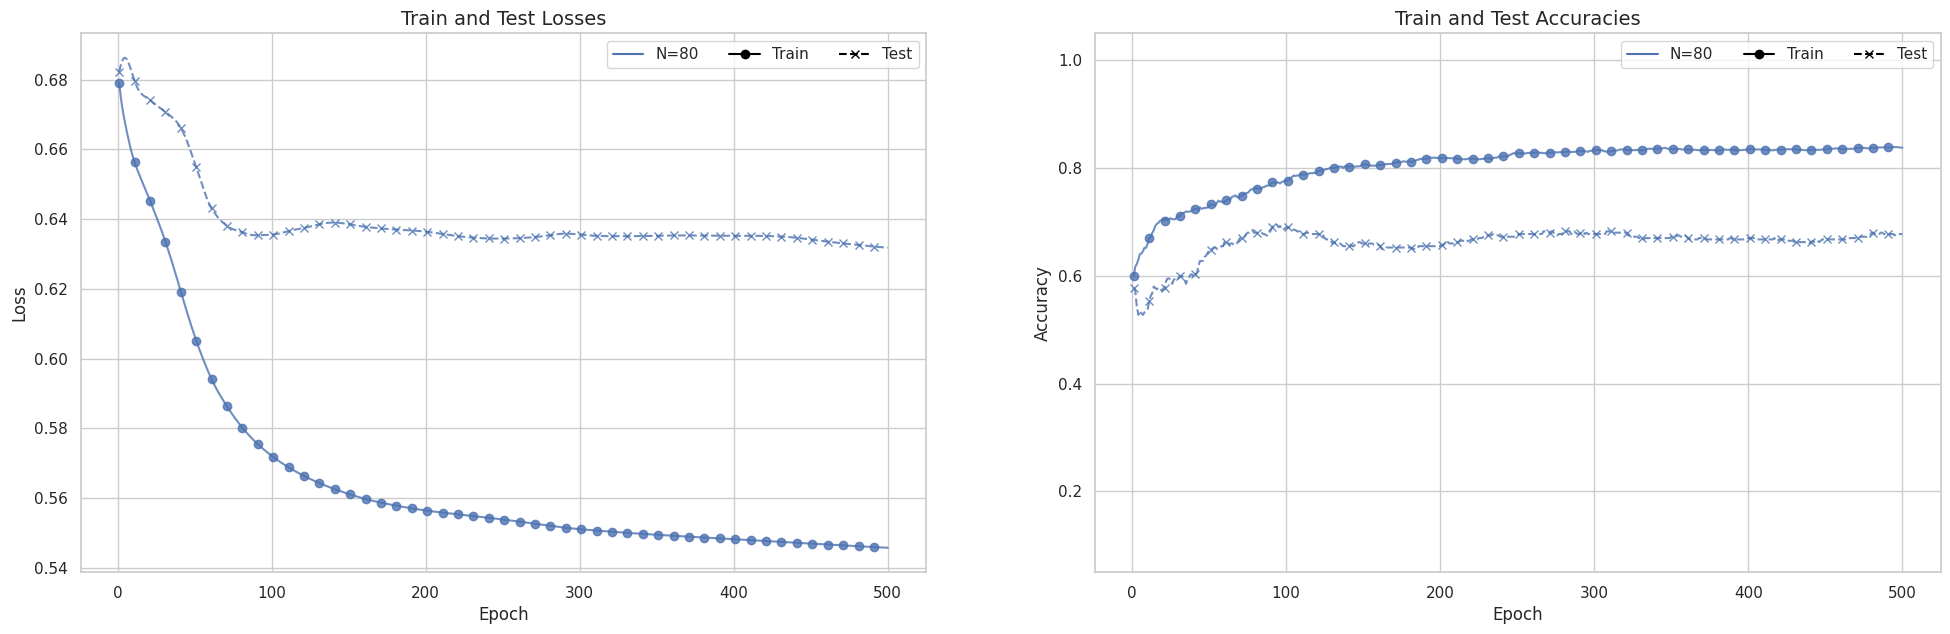

In [21]:
# aggregate dataframe
df_agg = results_df.groupby(["n_train", "step"]).agg(["mean", "std"])
df_agg = df_agg.reset_index()

sns.set_style('whitegrid')
colors = sns.color_palette()
fig, axes = plt.subplots(ncols=2, figsize=(24, 7))

generalization_errors = []

# plot losses and accuracies
for i, n_train in enumerate(train_sizes):
    df = df_agg[df_agg.n_train == n_train]

    dfs = [df.train_cost["mean"], df.test_cost["mean"], df.train_acc["mean"], df.test_acc["mean"]]
    lines = ["o-", "x--", "o-", "x--"]
    labels = [fr"$N={n_train}$", None, fr"$N={n_train}$", None]
    axs = [0,0,1,1]

    for k in range(4):
        ax = axes[axs[k]]
        ax.plot(df.step, dfs[k], lines[k], label=labels[k], markevery=10, color=colors[i], alpha=0.8)


    # plot final loss difference
    #dif = df[df.step == n_epochs].test_cost["mean"] - df[df.step == n_epochs].train_cost["mean"]
    #generalization_errors.append(dif)

# format loss plot
ax = axes[0]
ax.set_title('Train and Test Losses', fontsize=14)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# format generalization error plot
#ax = axes[1]
#ax.plot(train_sizes, generalization_errors, "o-", label=r"$gen(\alpha)$")
#ax.set_xscale('log')
#ax.set_xticks(train_sizes)
#ax.set_xticklabels(train_sizes)
#ax.set_title(r'Generalization Error $gen(\alpha) = R(\alpha) - \hat{R}_N(\alpha)$', fontsize=14)
#ax.set_xlabel('Training Set Size')

# format loss plot
ax = axes[1]
ax.set_title('Train and Test Accuracies', fontsize=14)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_ylim(0.05, 1.05)

legend_elements = [
    mpl.lines.Line2D([0], [0], label=f'N={n}', color=colors[i]) for i, n in enumerate(train_sizes)
    ] + [
    mpl.lines.Line2D([0], [0], marker='o', ls='-', label='Train', color='Black'),
    mpl.lines.Line2D([0], [0], marker='x', ls='--', label='Test', color='Black')
    ]

axes[0].legend(handles=legend_elements, ncol=3)
axes[1].legend(handles=legend_elements, ncol=3)

#axes[1].set_yscale('log', base=2)
plt.show()

In [22]:
save_folder = "/content/drive/MyDrive/Research/HermtianEncodingImg/ct-med-img"
results_df.to_csv(os.path.join(save_folder, "ct-med-img_HermReUpload_results.csv"))
df_agg.to_csv(os.path.join(save_folder, "ct-med-img_HermReUpload_results_agg.csv"))
# save the plot to file
fig.savefig(os.path.join(save_folder, "ct-med-img_HermReUpload_results.pdf"))